# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Rander metrics

In this notebook, we solve Rander eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and GPU in the Rander case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, two dimensional only, whereas the GPU version uses a non-causal (yet monotone) Eulerian scheme, in two and three dimensions.

In [8]:
large_instances = False # Set to True to show off GPU acceleration (CPU times may become a big long.)

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Constant metric](#1.1-Constant-metric)
    * [1.2 Zermelo's problem](#1.2-Zermelo's-problem)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU,RunSmart,Metrics
    HFMUtils,ad,cugen,Metrics = rreload([HFMUtils,ad,cugen,Metrics],"../..")    
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

## 1. Two dimensions

### 1.1 Constant metric

In [6]:
n=100
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
    'factoringRadius':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['metric'] = Metrics.Rander(cp.eye(2),cp.array([0.5,0.]) )

Casting output of function array from float64 to float32
Casting output of function eye from float64 to float32
Casting output of function array from float64 to float32


In [7]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.003)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.024994373321533203 seconds,  and 14 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.024 s.
Solver time (s). GPU : 0.024994373321533203, CPU : 0.046. Device acceleration : 1.8404142167617377
Max |gpuValues-cpuValues| :  0.002103818574902272


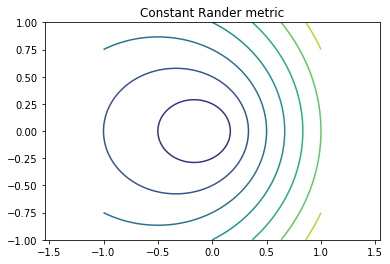

In [8]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

### 1.2 Zermelo's problem

We obtain $\times 40$ speedup at resolution $2000\times 2000$ already. The lack of causality does not seem to be a significant issue for the GPU solver. The cost of the FM-ASR adaptive stencils cannot be neglected. 

In [17]:
n=4000 if large_instances else 1000
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'seeds':cp.array([[0.,0.]]),
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)

Casting output of function array from float64 to float32


In [18]:
def Drift(x):
    mult = 0.9*np.sin(x[0])*np.sin(x[1]) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [11]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmIn.Grid()))

Casting output of function eye from float64 to float32


In [17]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.05);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.2019953727722168 seconds,  and 563 iterations.
Post-Processing
---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 66.22 s.
Max |gpuValues-cpuValues| :  0.013984917158148313
Solver time (s). GPU solver : 1.2019953727722168, CPU solver 66.22, CPU stencil Stencil 36.544.Device acceleration : 85.49450549297099


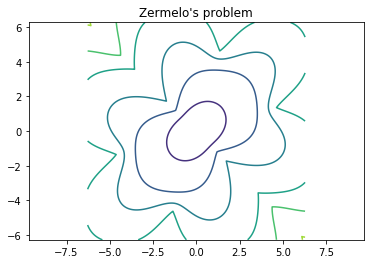

In [19]:
plt.title("Zermelo's problem"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

In [27]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for validation with multiple options
hfmInS.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
hfmInS.update({
    'metric' : Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmInS.Grid())),
    'verbosity':0,
    'exportGeodesicFlow':True,
})

Casting output of function eye from float64 to float32


In [28]:
RunCompare(hfmInS,variants=True,check=0.2)


--- Variant with {} and {'multiprecision': False} ---
Solver time (s). GPU : 0.020023584365844727, CPU : 0.188. Device acceleration : 9.388928403881646
Max |gpuValues-cpuValues| :  0.17485537015542807

--- Variant with {} and {'multiprecision': True} ---
Solver time (s). GPU : 0.022481441497802734, CPU : 0.193. Device acceleration : 8.58485876089677
Max |gpuValues-cpuValues| :  0.17455973111734213

--- Variant with {'seedRadius': 2.0} and {'multiprecision': False} ---
Solver time (s). GPU : 0.016498327255249023, CPU : 0.192. Device acceleration : 11.637543432708565
Max |gpuValues-cpuValues| :  0.16591726396115458

--- Variant with {'seedRadius': 2.0} and {'multiprecision': True} ---
Solver time (s). GPU : 0.024999141693115234, CPU : 0.193. Device acceleration : 7.720265054265932
Max |gpuValues-cpuValues| :  0.16562114808591044

--- Variant with {'factorizationRadius': 10, 'factorizationPointChoice': 'Key'} and {'multiprecision': False} ---
Solver time (s). GPU : 0.021999597549438477, 

## 2. Three dimensions

As mentioned in the introduction, the CPU variant does not handle three dimensional problems. We generalize here Zermelo's problem, for the sake of testing array broadcasting.

In [29]:
n=200
hfmIn = HFMUtils.dictIn({
    'model':'Rander3',
    'seeds':cp.array([[0.,0.,0.]]),
    'exportValues':1,
    'raiseOnNonConvergence':False,
})
side = [-2.*np.pi,2.*np.pi]
hfmIn.SetRect([side,side,side],dimx=n+1)

Casting output of function array from float64 to float32


In [30]:
def Drift(x):
    mult = 0.9*np.prod(np.sin(x)) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [31]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(3),Drift(hfmIn.Grid()))

Casting output of function eye from float64 to float32


In [33]:
gpuOut = RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.11548948287963867 seconds,  and 77 iterations.
Post-Processing
